In [60]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [67]:
# set some default
pd.set_option('display.float_format', str)
sns.set_palette('Spectral')

In [2]:
df = pd.read_pickle('data_Han/Han_df_cleaned')

In [3]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

# ASSUMPTIONS ON KEY FEATURES

 * location
 * living space, especially a good bathroom
 * House condition
 * distance to downtown/office
 * neighborhood

## list of things to explore

***LOCATION***
 * zipcode - area
 * waterfront/view important
 * neiborhood amenities
 * is height important?/flood
 
***LIVING SPACE*** 
 * bigger house sells more?
 * more bedrooms/bathrooms sells more?
 * more floors sells more?
 * space allocations
 * Floor Area Ratio sells more?
 
***HOUSE CONDITION***
* year built & renovated
* Age & condition

***NEIGHBORHOOD***
* amenities, parks, hospitals, etc...
* safety
 
***INVESTMENT***
 * year built
 * view/waterfront
 * flood zone/latitude
 
 
***OVERALL INTUITION***
 * sqrt_living
 * bedrooms/bathrooms
 * view/waterfront
 * zipcode
 * year_built

# EDA LOCATION

In [5]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


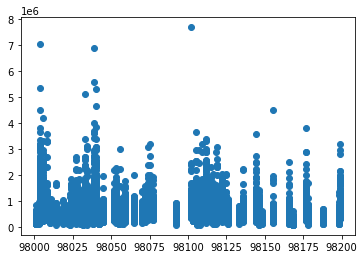

In [7]:
plt.scatter(x=df.zipcode,y=df.price)

In [8]:
df.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

#### which zipcode has highest average price

In [37]:
col_selector = ['price','zipcode','sqft_living']
df_loc = df[col_selector]
df_loc.head()

,price,zipcode,sqft_living
0,221900.0,98178,1180
1,538000.0,98125,2570
2,180000.0,98028,770
3,604000.0,98136,1960
4,510000.0,98074,1680


In [38]:
df_avg_price_zipcode = df_loc.groupby('zipcode').mean().sort_values(by='price')
df_avg_price_zipcode.head()

,price,sqft_living
zipcode,,
98002,234284.0351758794,1627.7437185929648
98168,240328.3717472119,1468.6245353159852
98032,251296.24,1738.048
98001,281194.8698060942,1903.7839335180056
98148,284908.5964912281,1610.5263157894738


In [44]:
df_avg_price_zipcode.shape

(70, 2)

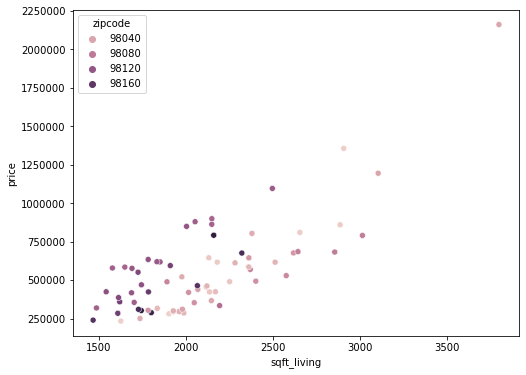

In [54]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(hue=df_avg_price_zipcode.index,
                y='price', x='sqft_living',
               data=df_avg_price_zipcode)
ax.ticklabel_format(style='plain');

# for i in range(df_avg_price_zipcode.shape[0]):
#     plt.text(x = df_avg_price_zipcode.sqft_living[i], y = df_avg_price_zipcode.price[i], s = df_avg_price_zipcode.index[i],fontsize=11);

# EDA LIVING SPACE

In [ ]:
col_selector = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_basement']
df_ls = df[col_selector]

Create new columns by combining

In [ ]:
# FAR
df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']

In [ ]:
df_ls.head()

In [ ]:
# Living space / bedrooms
# higher means you have more space for other rooms
# such as kitchen, living room, game room, home gym
df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']

### basic check

In [ ]:
df_ls.info()

In [ ]:
df_ls.describe()

In [ ]:
sns.pairplot(df_ls)

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_ls.corr(),annot = True,ax=ax)

***outstanding***
* sqft_living vs price
* sqft_living vs bathrooms/bedrooms
* bathroom corelates more with price
* living_space_VS_Bedrooms vs sqft_living


### check out FAR vs sqrt_lot

NameError: name 'df_ls' is not defined

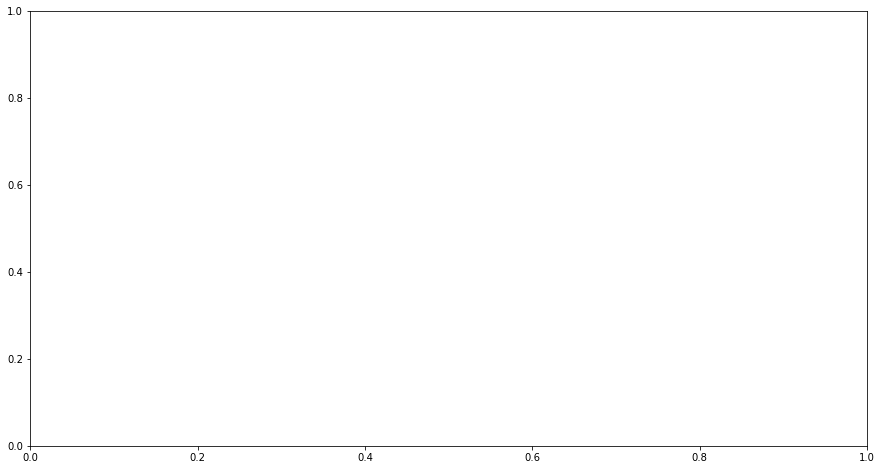

In [70]:
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(df_ls.FAR,df_ls.price,alpha=0.1)

In [ ]:
# can't tell too much now

## (test only) living space simple baseline model

In [ ]:
col_selector = ['sqft_living','bedrooms','Living_Space_VS_Bedroom','sqft_lot', 'floors']
X_ls = df_ls[col_selector]
y = df_ls.price

In [ ]:
X_ls_stand = X_ls.apply(lambda x: (x-x.mean()/x.std()))
y_stand = (y-y.mean())/y.std()

In [ ]:
ls_simple_model = sm.OLS(y_stand,sm.add_constant(X_ls_stand)).fit()

In [ ]:
print(ls_simple_model.summary())

## EDA HOUSE CONDITION

In [55]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [57]:
col_selector = ['price','grade','condition','yr_built', 'yr_renovated']
df_condition = df[col_selector]
df_condition.head()

,price,grade,condition,yr_built,yr_renovated
0,221900.0,7,2,1955,0.0
1,538000.0,7,2,1951,1991.0
2,180000.0,6,2,1933,0.0
3,604000.0,7,4,1965,0.0
4,510000.0,8,2,1987,0.0


<AxesSubplot:xlabel='condition', ylabel='price'>

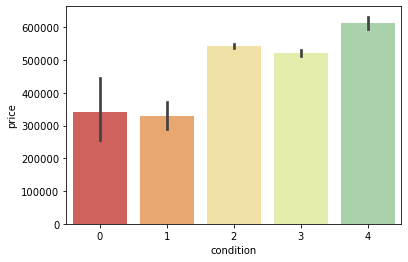

In [68]:
sns.barplot(x = 'condition', y = 'price', data = df_condition )

<AxesSubplot:xlabel='grade', ylabel='price'>

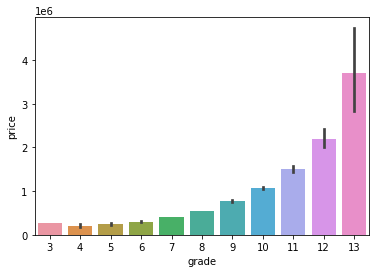

In [69]:
sns.barplot(x = 'grade', y = 'price', data = df_condition)

# EDA NEIGHBORHOOD

In [ ]:
col_selector = ['price','view','waterfront']
df_loc = df[col_selector]

In [ ]:
df_loc.head()

tips from other sources


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac1

https://www.bryanshalloway.com/2020/08/17/pricing-insights-from-historical-data-part-1/